In [1]:
# Development use only:
#import sys
#sys.path.insert(0, '/home/cameron/Projects/hypso-package/hypso/')



from hypso import Hypso
import os
import matplotlib.pyplot as plt

from hypso.satpy import get_l1a_satpy_scene, \
                        get_l1b_satpy_scene, \
                        get_l1c_satpy_scene, \
                        get_l1d_satpy_scene

from hypso.spectral_analysis import get_closest_wavelength_index
from hypso.geometry import compute_bbox
from hypso.geometry_definition import generate_area_def

#from satpy.composites import GenericCompositor
#from satpy.writers import to_image

from PIL import Image
#from pycoast import ContourWriterAGG

import numpy as np

from hypso.write import write_l1c_nc_file


import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from datetime import datetime
import csv
from pyresample import load_area
import glob
from satpy import Scene
from pyresample.future.resamplers.nearest import KDTreeNearestXarrayResampler
from pyresample.bilinear.xarr import XArrayBilinearResampler 
import pickle
import netCDF4 as nc
from hypso.geometry_definition import generate_hypso_swath_def

from hypso.classification import decode_jon_cnn_water_mask, decode_jon_cnn_land_mask, decode_jon_cnn_cloud_mask

from global_land_mask import globe

from scipy import linalg
from satpy import Scene
from pyresample.future.resamplers.nearest import KDTreeNearestXarrayResampler
from pyresample.geometry import SwathDefinition, AreaDefinition


In [2]:
pickle_file = '/home/cameron/aeronetvenice_2025-06-12T09-58-02Z_aeronetvenice_2025-06-22T10-46-15Z_iva_output.pickle'

sentinel_path_1 = '/media/veracrypt3/Sentinel_3/S3A_OL_2_WFR____20250612T090212_20250612T090512_20250613T165346_0179_127_050_2160_MAR_O_NT_003.SEN3'
sentinel_path_2 = '/media/veracrypt3/Sentinel_3/S3A_OL_2_WFR____20250622T094322_20250622T094622_20250623T163603_0179_127_193_2160_MAR_O_NT_003.SEN3'


In [104]:
with open(pickle_file, 'rb') as handle:
    iva_output = pickle.load(handle)


X1 = iva_output['X1']
X2 = iva_output['X2']
C1 = iva_output['C1']
C2 = iva_output['C2']

X1_lats = iva_output['X1_lats']
X1_lons = iva_output['X1_lons']
X2_lats = iva_output['X2_lats']
X2_lons = iva_output['X2_lons']


In [4]:
sentinel_paths = [sentinel_path_1, sentinel_path_2]

In [105]:
sentinel_granules = []
sentinel_tsm_granules = []
sentinel_coords = []

for sentinel_file in sentinel_paths:

    filenames = []
    filenames = filenames + glob.glob(sentinel_file + '/geo_coordinates.nc')
    filenames = filenames + glob.glob(sentinel_file + '/chl_nn.nc')
    filenames = filenames + glob.glob(sentinel_file + '/tsm_nn.nc')
    sentinel_scene = Scene(filenames=filenames, reader='olci_l2')
    sentinel_scene.load(['chl_nn', 'tsm_nn'])

    data = sentinel_scene['chl_nn']
    tsm_data = sentinel_scene['tsm_nn']

    s1 = sentinel_scene.to_xarray(include_lonlats=True)
    src_lats = s1['latitude'].to_numpy()
    src_lons = s1['longitude'].to_numpy()

    src_lats = xr.DataArray(src_lats, dims=['y', 'x'])
    src_lons = xr.DataArray(src_lons, dims=['y', 'x'])

    sentinel_coords.append((src_lats, src_lons))

    src_swath_def = SwathDefinition(lons=src_lons, lats=src_lats)

    dst_lons = xr.DataArray(X1_lons, dims=['y', 'x'])
    dst_lats = xr.DataArray(X1_lats, dims=['y', 'x'])

    dst_swath_def = SwathDefinition(lons=dst_lons, lats=dst_lats)

    nnrs = KDTreeNearestXarrayResampler(source_geo_def=src_swath_def, target_geo_def=dst_swath_def)
    resampled_data = nnrs.resample(data, fill_value=np.nan, radius_of_influence=500)
    resampled_tsm_data = nnrs.resample(tsm_data, fill_value=np.nan, radius_of_influence=500)

    resampled_data = resampled_data.to_numpy()
    resampled_tsm_data = resampled_tsm_data.to_numpy()

    sentinel_granules.append(resampled_data)
    sentinel_tsm_granules.append(resampled_tsm_data)

/home/cameron/.venv/lib/python3.13/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_dataset(f_obj,
/home/cameron/.venv/lib/python3.13/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_dataset(f_obj,
/home/cameron/.venv/lib/python3.13/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_dataset(f_obj,
/home/cameron/.venv/lib/python3.13/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The s

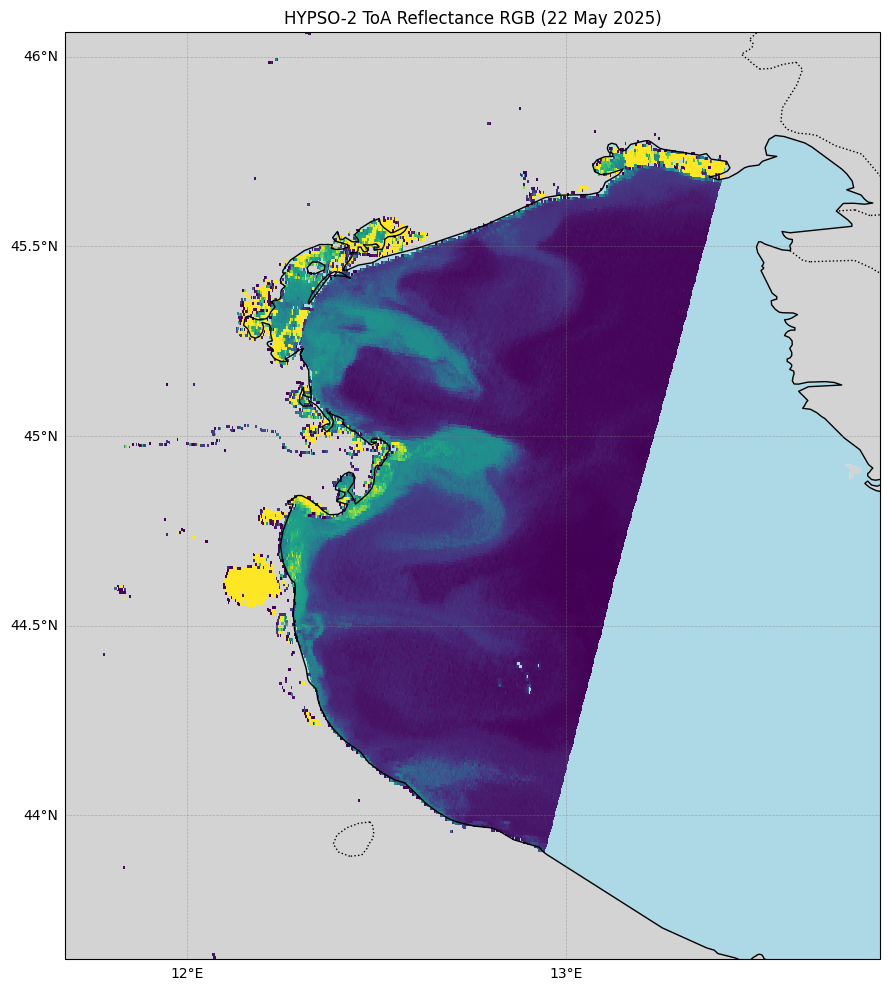

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(9, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())


# Plot the resampled data
#mesh = ax.pcolormesh(X1_lons, X1_lats, X1[3,:,:], transform=ccrs.PlateCarree())
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)

# Add basemap 
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Reduce longitude label density
import matplotlib.ticker as mticker
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 1))  # Change 10 to a larger value like 15 or 30 for fewer labels

# Add colorbar
#cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30)
#cbar.set_label('Chlorophyll Concentration (mg/m³)')

plt.title("HYPSO-2 ToA Reflectance RGB (22 May 2025)")
plt.tight_layout()
#plt.savefig('rgb.png')



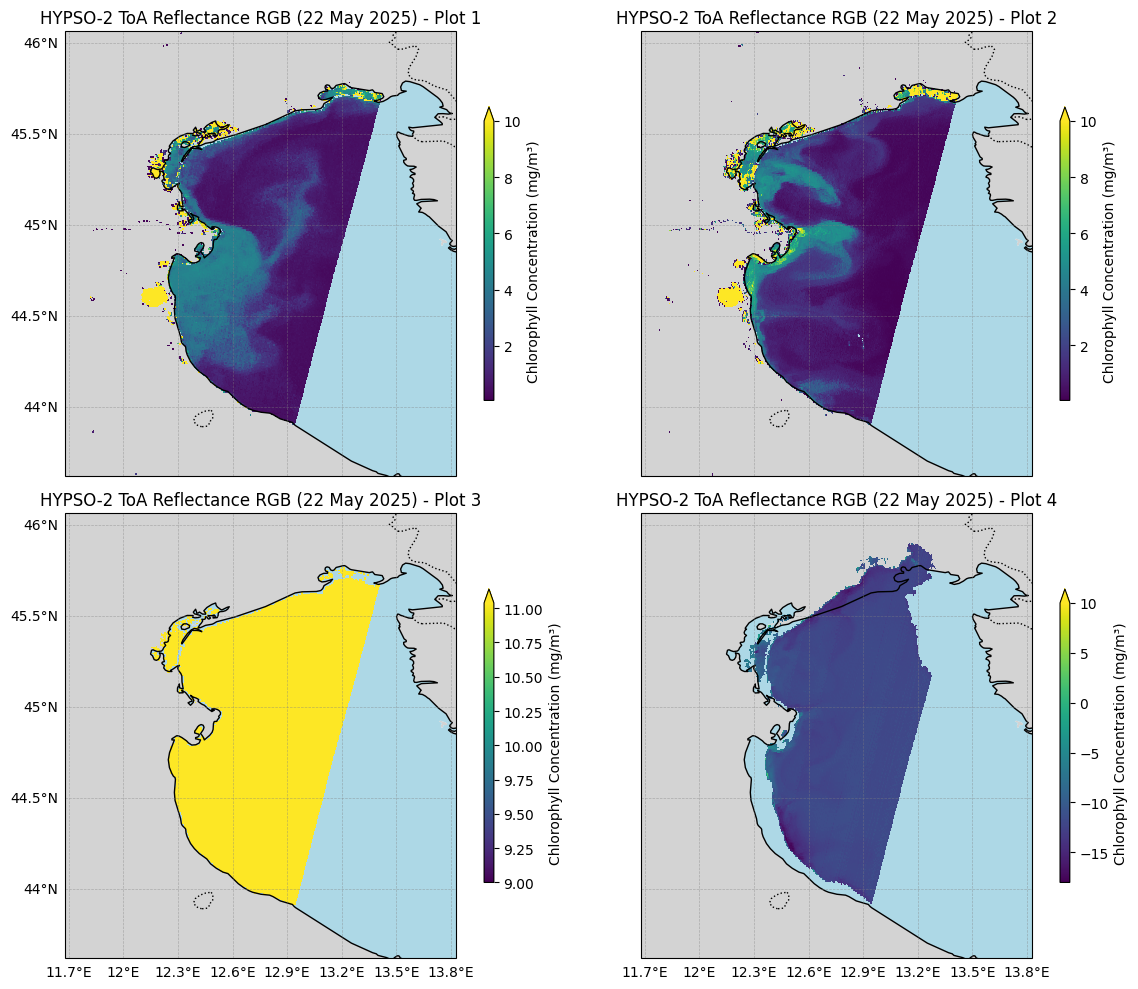

In [12]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker

data_to_plot = [10**sentinel_granules[0][:,:], 
                10**sentinel_granules[1][:,:],
                X1[0,:,:],
                X2[1,:,:]
                ]


# Create figure and 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for i, ax in enumerate(axs.flat):
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Plot the resampled data (you can vary the data per subplot if needed)
    mesh = ax.pcolormesh(X1_lons, X1_lats, data_to_plot[i], transform=ccrs.PlateCarree(), vmax=10)

    # Add basemap features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    

    # Remove y-axis labels for second column
    if i % 2 == 1:
        gl.left_labels = False

    # Remove x-axis labels for first row
    if i < 2:
        gl.bottom_labels = False


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30)
    cbar.set_label('Chlorophyll Concentration (mg/m³)')

    # Title for each subplot
    ax.set_title(f"HYPSO-2 ToA Reflectance RGB (22 May 2025) - Plot {i+1}")

plt.tight_layout()
# plt.savefig('subplot_rgb.png')
plt.show()


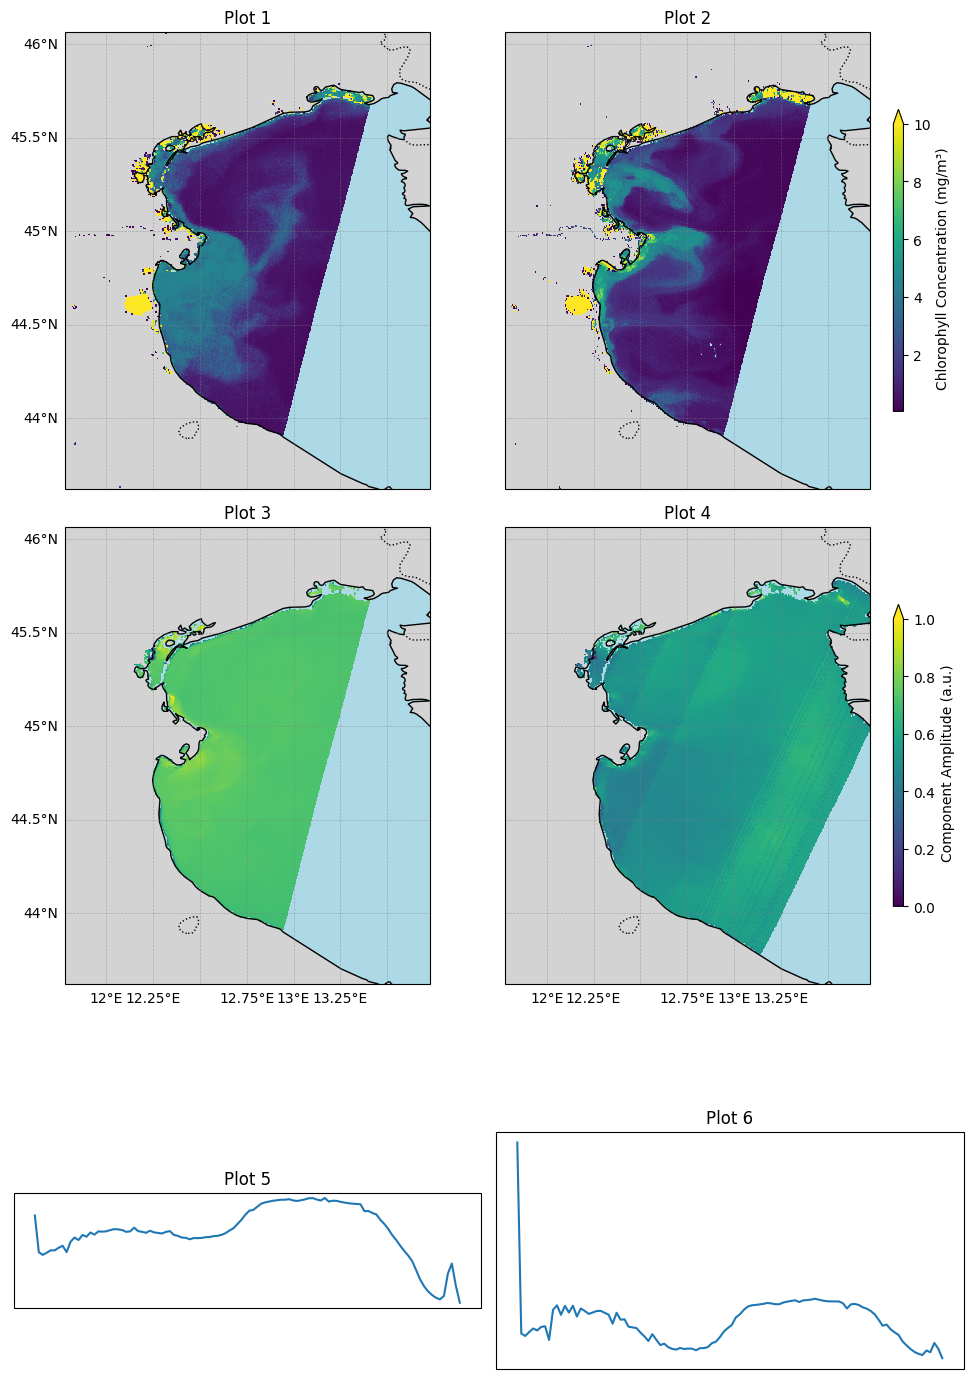

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker

extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

component = 4
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))

fig, axs = plt.subplots(3, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Dummy data (replace with your actual data)
#extent = [-180, 180, -90, 90]
#X1_lons, X1_lats = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-90, 90, 50))
#data = 10**np.random.rand(50, 100)

# Subplot 1 (Top-left)
ax = axs[0, 0]
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[0][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False  # Remove x-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("Plot 1")

# Subplot 2 (Top-right)
ax = axs[0, 1]
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False  # Remove x-axis labels
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("Plot 2")

# Subplot 3 (Bottom-left)
ax = axs[1, 0]
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("Plot 3")

# Subplot 4 (Bottom-right)
ax = axs[1, 1]
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("Plot 4")



ax = axs[2, 0]
ax.plot(C1[4,:])
ax.set_title("Plot 5")



ax = axs[2, 1]
ax.plot(C2[4,:])
ax.set_title("Plot 6")




plt.tight_layout()
plt.show()

In [81]:
wavelengths = [379.8273177 , 383.35406375, 386.87964394, 390.40405827,
       393.92730673, 397.44938932, 400.97030605, 404.49005691,
       408.0086419 , 411.52606103, 415.0423143 , 418.5574017 ,
       422.07132323, 425.5840789 , 429.0956687 , 432.60609264,
       436.11535071, 439.62344292, 443.13036926, 446.63612974,
       450.14072435, 453.64415309, 457.14641597, 460.64751298,
       464.14744413, 467.64620941, 471.14380883, 474.64024238,
       478.13551006, 481.62961188, 485.12254784, 488.61431793,
       492.10492215, 495.59436051, 499.082633  , 502.56973963,
       506.05568039, 509.54045529, 513.02406432, 516.50650748,
       519.98778478, 523.46789621, 526.94684178, 530.42462149,
       533.90123532, 537.37668329, 540.8509654 , 544.32408164,
       547.79603202, 551.26681653, 554.73643517, 558.20488795,
       561.67217486, 565.13829591, 568.60325109, 572.06704041,
       575.52966386, 578.99112144, 582.45141316, 585.91053902,
       589.368499  , 592.82529313, 596.28092139, 599.73538378,
       603.1886803 , 606.64081097, 610.09177576, 613.54157469,
       616.99020776, 620.43767495, 623.88397629, 627.32911176,
       630.77308136, 634.21588509, 637.65752297, 641.09799497,
       644.53730111, 647.97544139, 651.4124158 , 654.84822434,
       658.28286702, 661.71634383, 665.14865478, 668.57979986,
       672.00977908, 675.43859243, 678.86623991, 682.29272153,
       685.71803728, 689.14218717, 692.5651712 , 695.98698935,
       699.40764164, 702.82712807, 706.24544863, 709.66260333,
       713.07859216, 716.49341512, 719.90707222, 723.31956345,
       726.73088882, 730.14104832, 733.55004196, 736.95786973,
       740.36453163, 743.77002767, 747.17435785, 750.57752216,
       753.9795206 , 757.38035318, 760.78001989, 764.17852074,
       767.57585572, 770.97202484, 774.36702809, 777.76086547,
       781.15353699, 784.54504264, 787.93538243, 791.32455635]

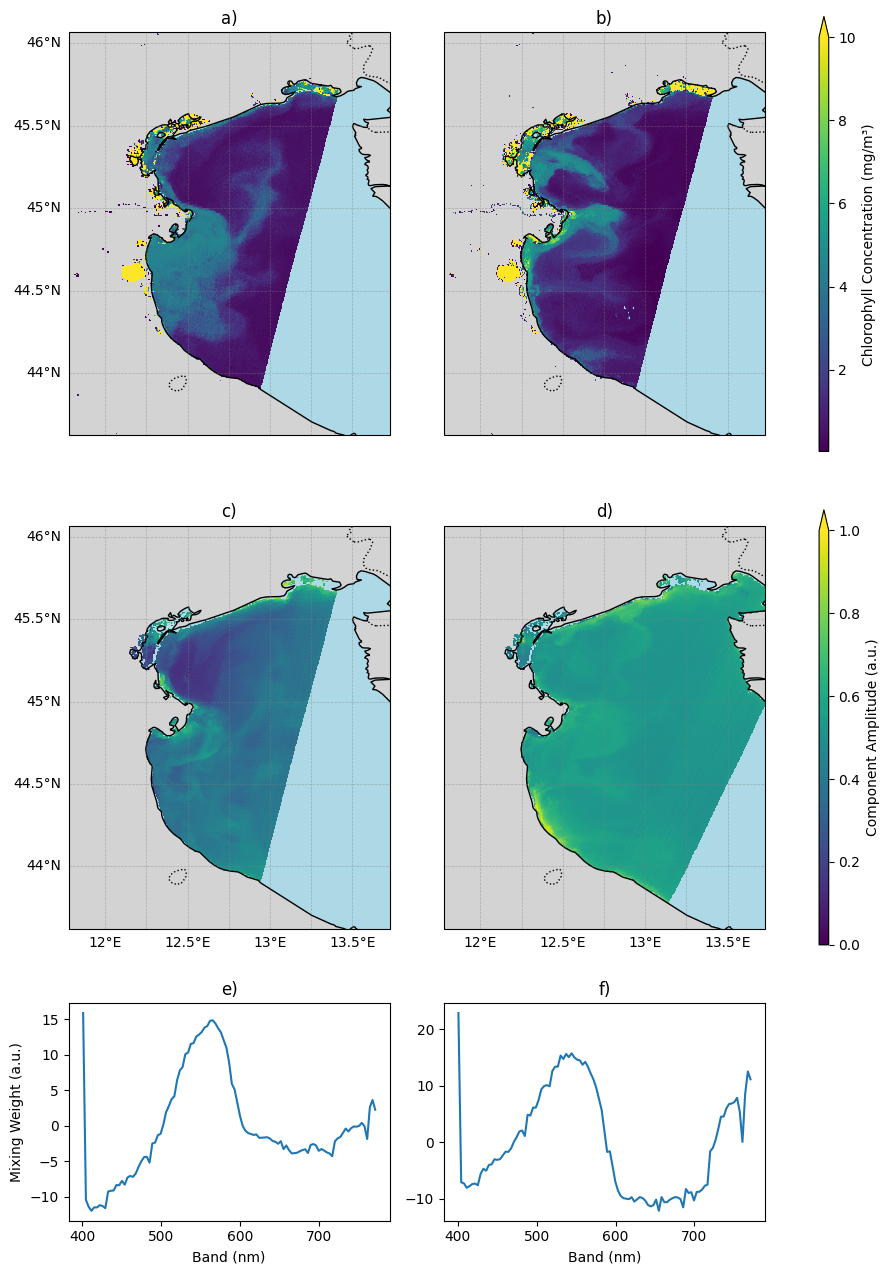

In [83]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec




extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

component = 2
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))

mixing_1 = C1[component,:]
mixing_2 = C2[component,:]

#fig, axs = plt.subplots(3, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

fig = plt.figure(figsize=(9, 13))


gs = GridSpec(3, 3, width_ratios=[1, 1, 0.03], height_ratios=[1, 1, 0.5])



# Top row
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

# Middle row
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
cax2 = fig.add_subplot(gs[1, 2])

# Bottom row (line plots)
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


# Subplot 1 (Top-left)
ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[0][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False  # Remove x-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

# Subplot 2 (Top-right)
ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False  # Remove x-axis labels
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("b)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', extend='max', shrink=0.5).set_label('Chlorophyll Concentration (mg/m³)')



# Subplot 3 (Bottom-left)
ax = ax3
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("c)")

# Subplot 4 (Bottom-right)
ax = ax4
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("d)")

ax = cax1
fig.colorbar(mesh, cax=cax2, orientation='vertical', shrink=0.5, extend='max').set_label('Component Amplitude (a.u.)')


ax = ax5
ax.plot(wavelengths[6:-6], mixing_1)
ax.set_title("e)")
ax.set_ylabel('Mixing Weight (a.u.)')
ax.set_xlabel('Band (nm)')


ax = ax6
ax.plot(wavelengths[6:-6], mixing_2)
ax.set_title("f)")
ax.set_xlabel('Band (nm)')
#ax.set_ylim(top=10)  




plt.tight_layout()
plt.savefig('aeronetvenice')
plt.show()



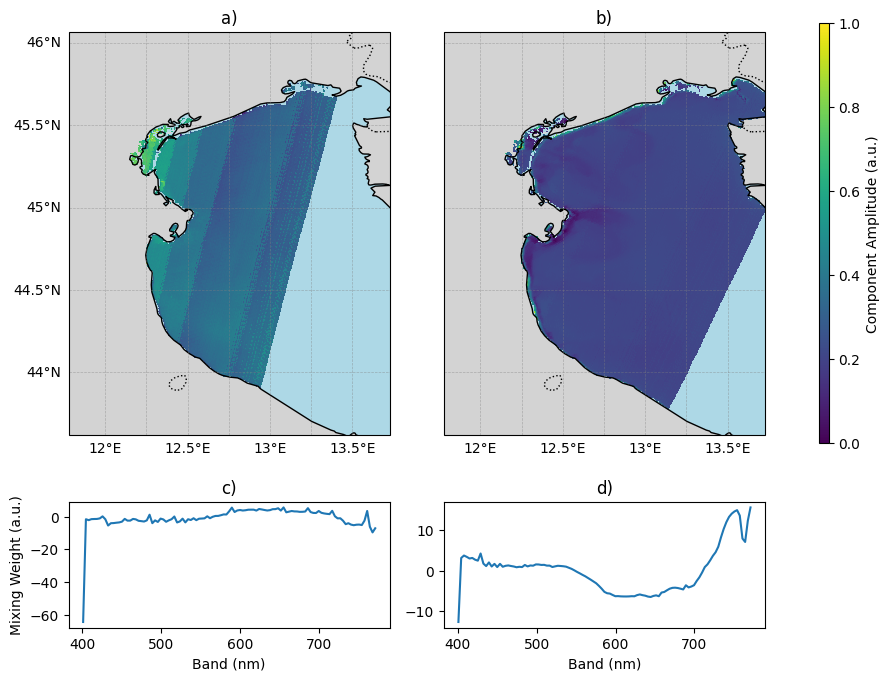

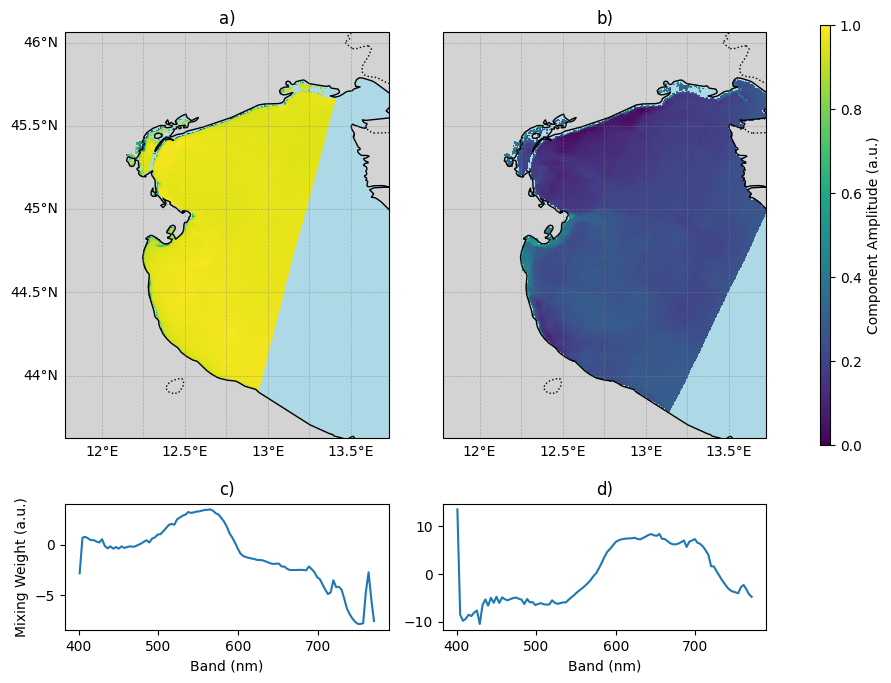

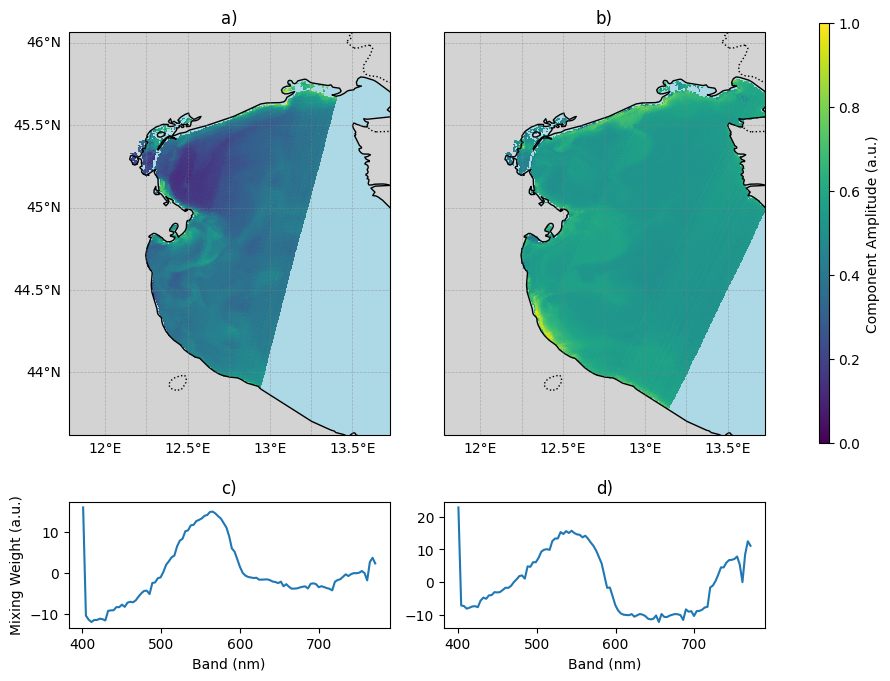

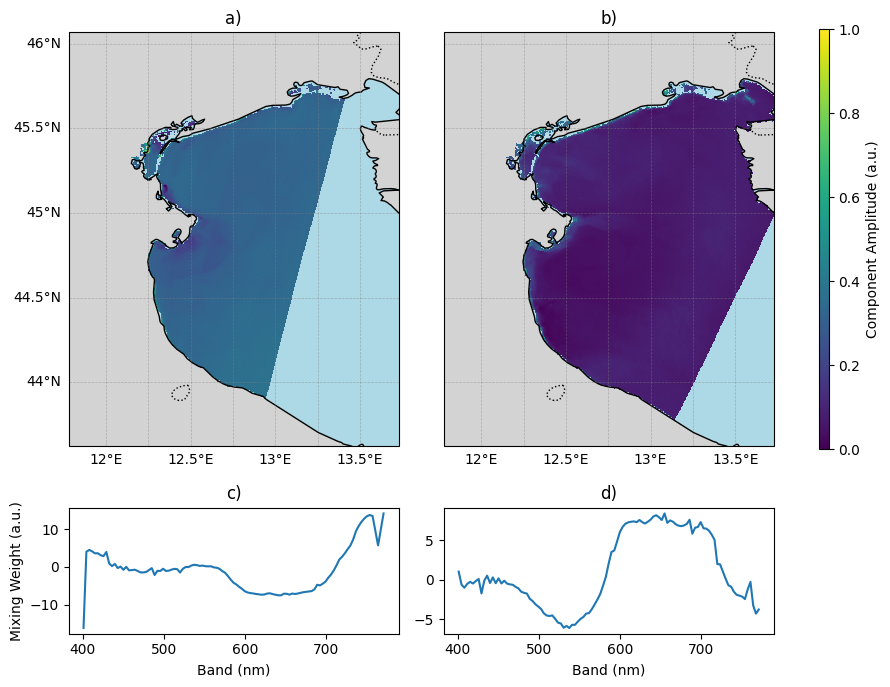

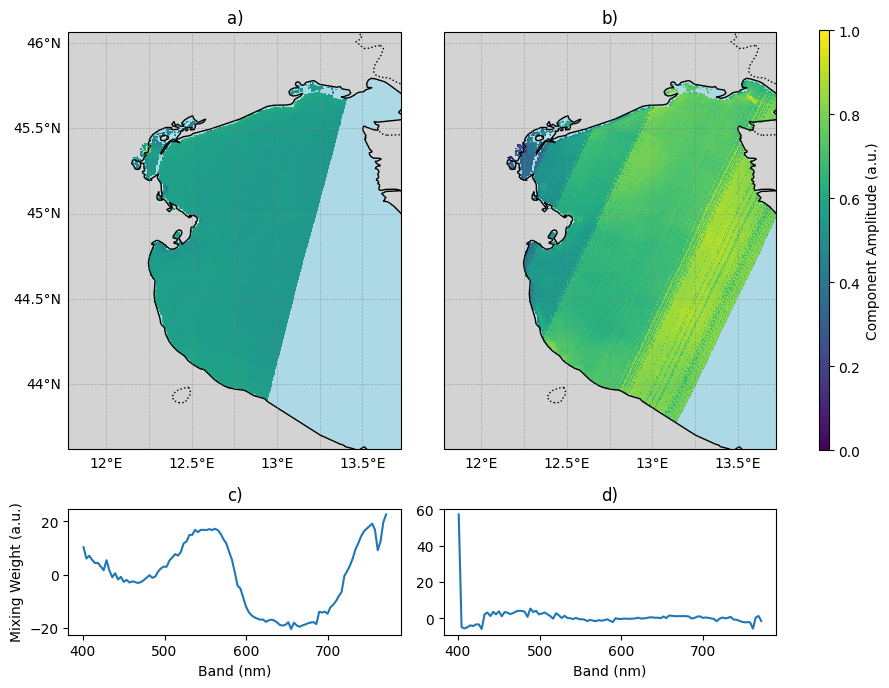

In [121]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]



#fig, axs = plt.subplots(3, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

for component in range(0,5):

    fig = plt.figure(figsize=(9, 7))

    gs = GridSpec(2, 3, width_ratios=[1, 1, 0.03], height_ratios=[1, 0.3])

    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    cax1 = fig.add_subplot(gs[0, 2])

    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])


    #component = 0
    X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
    X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))
    mixing_1 = C1[component,:]
    mixing_2 = C2[component,:]

    ax = ax1
    ax.set_extent(extent)
    mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    #gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
    ax.set_title("a)")

    ax = ax2
    ax.set_extent(extent)
    mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False    # Remove y-axis labels
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    #gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
    ax.set_title("b)")

    ax = cax1
    fig.colorbar(mesh, cax=cax1, orientation='vertical').set_label('Component Amplitude (a.u.)')
    #fig.colorbar(mesh, ax=[ax2], orientation='vertical', fraction=0.046, pad=0.04)

    #cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    #fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', extend='max')


    ax = ax3
    ax.plot(wavelengths[6:-6], mixing_1)
    ax.set_title("c)")
    ax.set_ylabel('Mixing Weight (a.u.)')
    ax.set_xlabel('Band (nm)')

    ax = ax4
    ax.plot(wavelengths[6:-6], mixing_2)
    ax.set_title("d)")
    ax.set_xlabel('Band (nm)')


    plt.tight_layout()
    plt.savefig('aeronetvenice_component_' + str(component))
    plt.show()



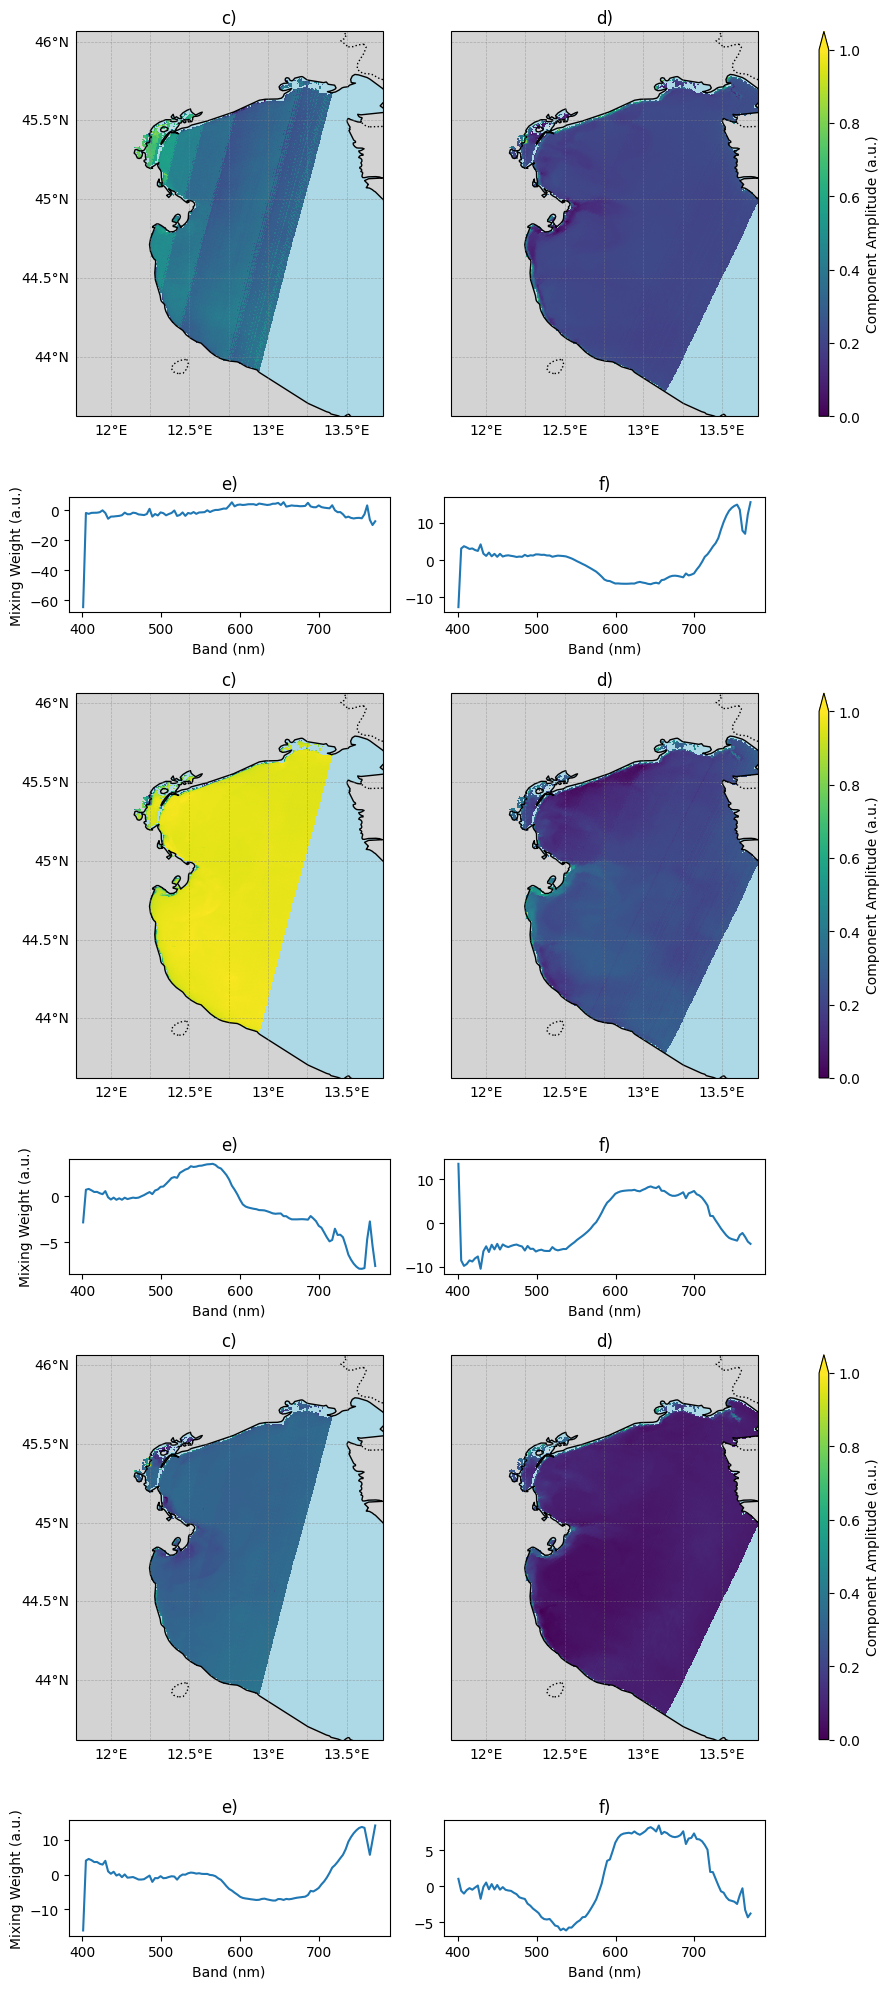

In [110]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]



#fig, axs = plt.subplots(3, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

fig = plt.figure(figsize=(9, 20))


gs = GridSpec(6, 3, width_ratios=[1, 1, 0.03], height_ratios=[1, 0.3, 1, 0.3, 1, 0.3])


ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])


ax5 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
cax2 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])


ax9 = fig.add_subplot(gs[4, 0], projection=ccrs.PlateCarree())
ax10 = fig.add_subplot(gs[4, 1], projection=ccrs.PlateCarree())
cax3 = fig.add_subplot(gs[4, 2])

ax11 = fig.add_subplot(gs[5, 0])
ax12 = fig.add_subplot(gs[5, 1])





component = 0
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))
mixing_1 = C1[component,:]
mixing_2 = C2[component,:]

ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("c)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("d)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', shrink=0.5, extend='max').set_label('Component Amplitude (a.u.)')

ax = ax3
ax.plot(wavelengths[6:-6], mixing_1)
ax.set_title("e)")
ax.set_ylabel('Mixing Weight (a.u.)')
ax.set_xlabel('Band (nm)')

ax = ax4
ax.plot(wavelengths[6:-6], mixing_2)
ax.set_title("f)")
ax.set_xlabel('Band (nm)')





component = 1
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))
mixing_1 = C1[component,:]
mixing_2 = C2[component,:]

ax = ax5
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("c)")

ax = ax6
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("d)")

ax = cax2
fig.colorbar(mesh, cax=cax2, orientation='vertical', shrink=0.5, extend='max').set_label('Component Amplitude (a.u.)')

ax = ax7
ax.plot(wavelengths[6:-6], mixing_1)
ax.set_title("e)")
ax.set_ylabel('Mixing Weight (a.u.)')
ax.set_xlabel('Band (nm)')

ax = ax8
ax.plot(wavelengths[6:-6], mixing_2)
ax.set_title("f)")
ax.set_xlabel('Band (nm)')





component = 3
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))
mixing_1 = C1[component,:]
mixing_2 = C2[component,:]

ax = ax9
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, X1_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("c)")

ax = ax10
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, X2_normalized, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("d)")

ax = cax3
fig.colorbar(mesh, cax=cax3, orientation='vertical', shrink=0.5, extend='max').set_label('Component Amplitude (a.u.)')

ax = ax11
ax.plot(wavelengths[6:-6], mixing_1)
ax.set_title("e)")
ax.set_ylabel('Mixing Weight (a.u.)')
ax.set_xlabel('Band (nm)')

ax = ax12
ax.plot(wavelengths[6:-6], mixing_2)
ax.set_title("f)")
ax.set_xlabel('Band (nm)')




plt.tight_layout()
plt.savefig('aeronetvenice_components')
plt.show()



In [6]:
class HypsoCapture:
    def __init__(self, nc_file=None):

        self.nc_file = nc_file


        dir_path = os.path.dirname(nc_file)
        print(dir_path)

        self.cnn_labels_file = os.path.join(dir_path, '/processing-temp', 'sea-land-cloud.labels')
        self.latitudes_file = os.path.join(dir_path, 'processing-temp', 'latitudes_indirectgeoref.dat')
        self.longitudes_file = os.path.join(dir_path, 'processing-temp', 'longitudes_indirectgeoref.dat')
        self.cnn_labels = os.path.join(dir_path, 'processing-temp', 'sea-land-cloud.labels')


In [7]:
capture_1 = HypsoCapture('/media/veracrypt3/HYPSO/aeronetvenice_2025-06-12T09-58-02Z/aeronetvenice_2025-06-12T09-58-02Z-l1a.nc')
capture_2 = HypsoCapture('/media/veracrypt3/HYPSO/aeronetvenice_2025-06-22T10-46-15Z/aeronetvenice_2025-06-22T10-46-15Z-l1a.nc')

captures = [capture_1, capture_2]

/media/veracrypt3/HYPSO/aeronetvenice_2025-06-12T09-58-02Z
/media/veracrypt3/HYPSO/aeronetvenice_2025-06-22T10-46-15Z


In [124]:
processed_captures = []

for capture in captures:
    
    # Load HYPSO-1 Capture
    satobj = Hypso(path=capture.nc_file, verbose=True)

    satobj.generate_l1b_cube()
    satobj.generate_l1c_cube()
    satobj.generate_l1d_cube()

    # Read from latitudes_indirectgeoref.dat
    with open(capture.latitudes_file, mode='rb') as file:
        file_content = file.read()

    lats = np.frombuffer(file_content, dtype=np.float32)

    lats = lats.reshape(satobj.spatial_dimensions)

    # Read from longitudes_indirectgeoref.dat
    with open(capture.longitudes_file, mode='rb') as file:
        file_content = file.read()

    lons = np.frombuffer(file_content, dtype=np.float32)

    lons = lons.reshape(satobj.spatial_dimensions)

    # Directly provide the indirect lat/lons loaded from the file. This function will run the track geometry computations.
    satobj.run_indirect_georeferencing(latitudes=lats, longitudes=lons)

    processed_captures.append(satobj)


[INFO] Loading L1a capture aeronetvenice_2025-06-12T09-58-02Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running spectral correction...
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 539
[INFO] ADCS time range: 1749721620.000000 to 1749722550.000000
[INFO] Frame time range: 1749722282.591261 to 1749722357.216261
[INFO] 298 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry computations...
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
[INFO] Track geometry computations done.
[INFO] Running angles geometry computations...
[INFO] Computing local angles (sun and satellite azimuth and zenith angles) ...
[INFO] Using astropy on a subsampling of pixels ... (TODO

In [125]:
from pyresample.geometry import SwathDefinition
from pyresample.geometry import SwathDefinition, AreaDefinition
from pyresample.bilinear.xarr import XArrayBilinearResampler 
from pyresample.future.resamplers.nearest import KDTreeNearestXarrayResampler

In [126]:
from hypso.geometry_definition import generate_area_def

new_bbox = processed_captures[0].bbox

area_def = generate_area_def(area_id = 'New area',
                            proj_id = 'id',
                            description = 'new area',
                            bbox = new_bbox,
                            height = 512,
                            width = 512
                            )

# Display area information
area_def

Area ID: New area
Description: id
Projection ID: new area
Projection: {'ellps': 'bessel', 'lat_0': '90', 'lat_ts': '45.2940098809817', 'lon_0': '12.5107801869658', 'no_defs': 'None', 'proj': 'stere', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 512
Number of rows: 512
Area extent: (-106274.8409, -4758914.8709, 94485.2957, -4230987.0788)

In [134]:
del rgb_images

(598, 1092, 3)
(598, 1092, 3)


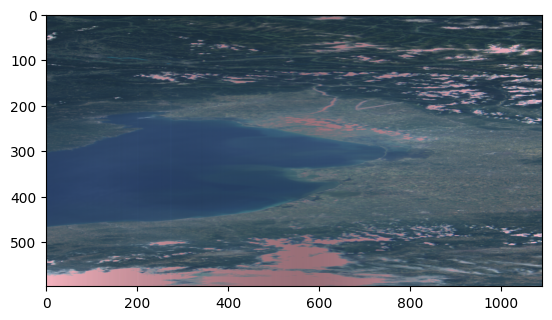

In [137]:
from hypso.spectral_analysis import get_closest_wavelength_index

rgba_images = []

for capture in processed_captures:

    satobj = capture

    #satobj = processed_captures[0]


    red_wl = 630
    green_wl = 550
    blue_wl = 480

    red_idx = get_closest_wavelength_index(satobj, red_wl)
    green_idx = get_closest_wavelength_index(satobj, green_wl)
    blue_idx = get_closest_wavelength_index(satobj, blue_wl)


    red = satobj.l1d_cube[:,:,red_idx]
    green = satobj.l1d_cube[:,:,green_idx]
    blue = satobj.l1d_cube[:,:,blue_idx]

    #dims_2d = ['y', 'x']

    #latitudes_xr = xr.DataArray(satobj.latitudes_indirect, dims=dims_2d)
    #longitudes_xr = xr.DataArray(satobj.longitudes_indirect, dims=dims_2d)

    #swath_def = SwathDefinition(lons=longitudes_xr, lats=latitudes_xr)

    #kdtn = KDTreeNearestXarrayResampler(source_geo_def=swath_def, target_geo_def=area_def)

    #resampled_red = kdtn.resample(data=red, fill_value=np.nan, radius_of_influence=500)
    #resampled_green = kdtn.resample(data=green[:,:].to_numpy(), fill_value=np.nan, radius_of_influence=500)
    #resampled_blue = kdtn.resample(data=blue[:,:].to_numpy(), fill_value=np.nan, radius_of_influence=500)

    rgb_image = np.stack((red, green, blue), axis=-1)

    print(rgb_image.shape)

    max_value = np.nanmax(rgb_image)
    rgb_image = rgb_image/max_value*255

    rgb_image = rgb_image.astype(np.uint8)

    # Create alpha channel: 0 where RGB is (0,0,0), else 255
    alpha = np.where(np.all(rgb_image == [0, 0, 0], axis=-1), 0, 255).astype(np.uint8)

    # Combine RGB and alpha into RGBA image
    rgba_image = np.dstack((rgb_image, alpha))

    plt.imshow(rgba_image)

    rgba_images.append(rgba_image)

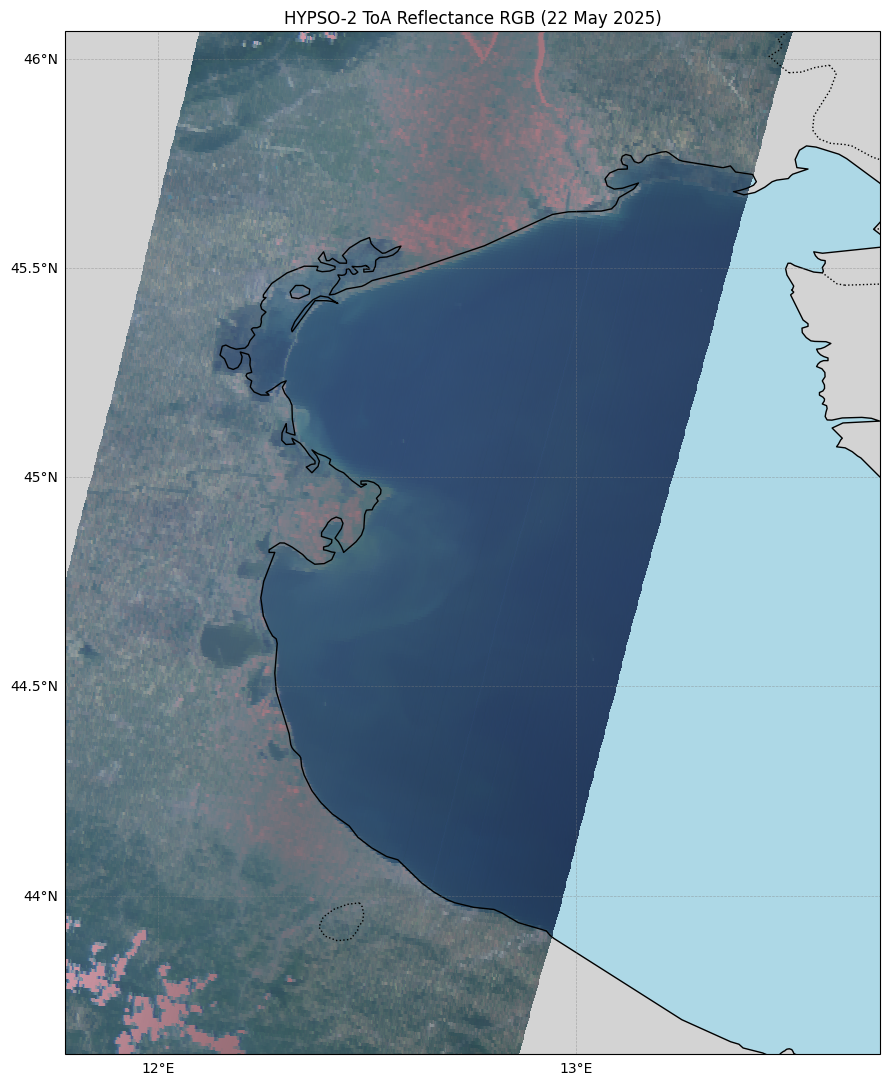

In [142]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.figure(figsize=(9, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Define colors
M,N = red.shape
facecolors = rgba_image.reshape(-1, 4)
facecolors = [tuple(fc) for fc in facecolors]

# Plot the resampled data
#mesh = ax.pcolormesh(satobj.longitudes_indirect, satobj.latitudes_indirect, rgba_images[1][:,:,:], facecolors=facecolors, transform=ccrs.PlateCarree())
mesh = ax.pcolormesh(X1_lons, X1_lats, rgba_images[0][:,:,:], facecolors=facecolors, transform=ccrs.PlateCarree())
#mesh = ax.pcolormesh(X2_lons, X2_lats, rgba_images[1][:,:,:], facecolors=facecolors, transform=ccrs.PlateCarree())

# Add basemap 
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Reduce longitude label density
import matplotlib.ticker as mticker
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 1))  # Change 10 to a larger value like 15 or 30 for fewer labels

# Add colorbar
#cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30)
#cbar.set_label('Chlorophyll Concentration (mg/m³)')

plt.title("HYPSO-2 ToA Reflectance RGB (22 May 2025)")
plt.tight_layout()
plt.savefig('rgb.png')



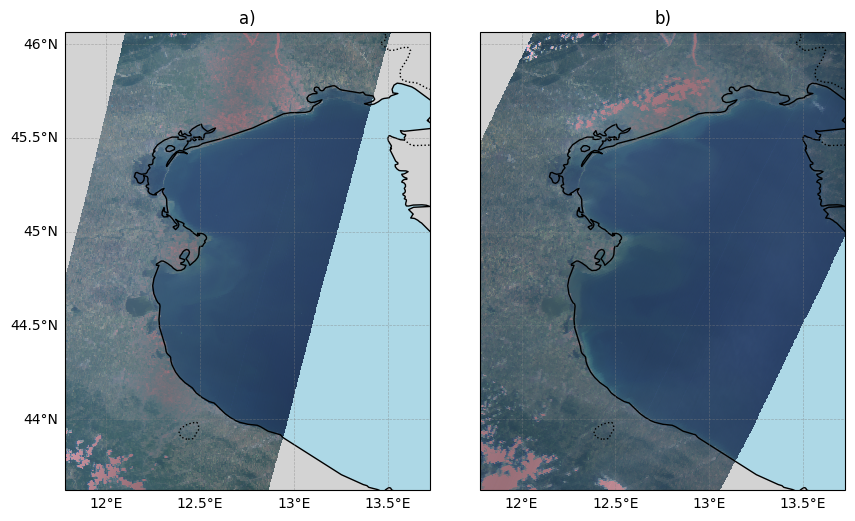

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

fig = plt.figure(figsize=(9, 5.25))

gs = GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())


ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, rgba_images[0][:,:,:], transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X2_lons, X2_lats, rgba_images[1][:,:,:], transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))  
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("b)")

plt.tight_layout()
plt.savefig('aeronetvenice_rgb')
plt.show()



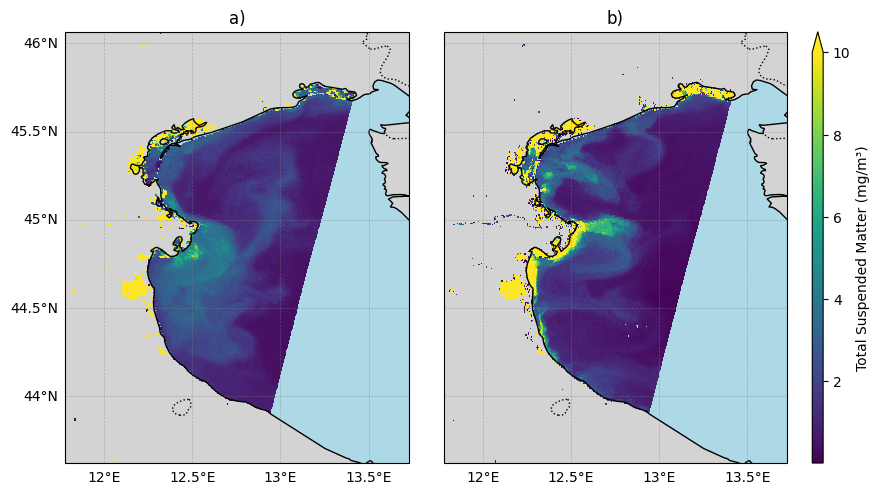

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

fig = plt.figure(figsize=(9, 5))

gs = GridSpec(1, 3, width_ratios=[1, 1, 0.03], height_ratios=[1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_tsm_granules[0][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_tsm_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))  
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("b)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', extend='max', shrink=0.5).set_label('Total Suspended Matter (mg/m³)')

plt.tight_layout()
plt.savefig('aeronetvenice_s3_tsm')
plt.show()



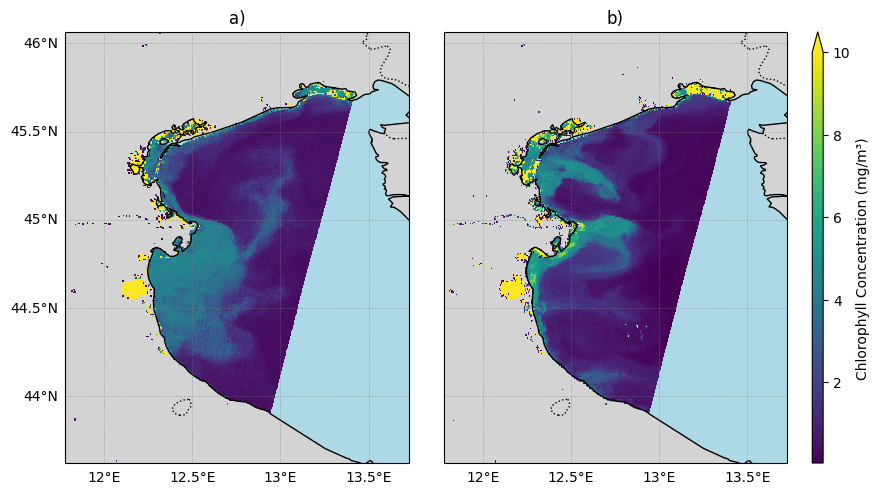

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

fig = plt.figure(figsize=(9, 5))

gs = GridSpec(1, 3, width_ratios=[1, 1, 0.03], height_ratios=[1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[0][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))  
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("b)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', extend='max', shrink=0.5).set_label('Chlorophyll Concentration (mg/m³)')

plt.tight_layout()
plt.savefig('aeronetvenice_s3_chl')
plt.show()



In [72]:
component = 2
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))

X1_normalized = X1[component,:,:]
X2_normalized = X2[component,:,:]

In [73]:
X1_centered = X1_normalized #+ np.nanmin(X1_normalized)
X2_centered = X2_normalized #+ np.nanmean(X2_normalized)

In [74]:
src_lons = xr.DataArray(X2_lons, dims=['y', 'x'])
src_lats = xr.DataArray(X2_lats, dims=['y', 'x'])
src_swath_def = SwathDefinition(lons=src_lons, lats=src_lats)

dst_lons = xr.DataArray(X1_lons, dims=['y', 'x'])
dst_lats = xr.DataArray(X1_lats, dims=['y', 'x'])
dst_swath_def = SwathDefinition(lons=dst_lons, lats=dst_lats)

nnrs = KDTreeNearestXarrayResampler(source_geo_def=src_swath_def, target_geo_def=dst_swath_def)
X2_centered = nnrs.resample(X2_centered, fill_value=np.nan, radius_of_influence=500)


/tmp/ipykernel_5421/1097579312.py:10: PerformanceWarning: KDTreeNearestXarrayResampler uses a dask-based implementation, but a pure numpy array was provided. Data will be converted to dask arrays for computation and then converted back. To avoid this warning convert your numpy array before providing it to the resampler.
  X2_centered = nnrs.resample(X2_centered, fill_value=np.nan, radius_of_influence=500)


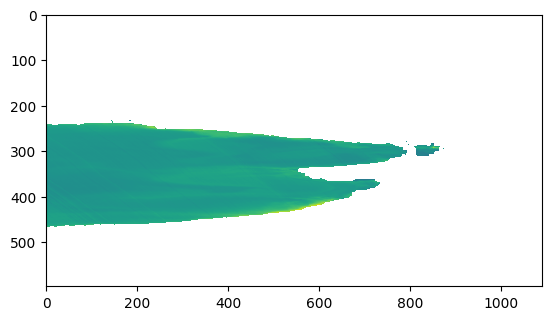

In [75]:
plt.imshow(X2_centered)

In [83]:
diff_hypso = X2_centered - X1_centered
diff_s3 = 10**sentinel_granules[1][:,:] - 10**sentinel_granules[0][:,:]
diff_tsm_s3 = 10**sentinel_tsm_granules[1][:,:] - 10**sentinel_tsm_granules[0][:,:]

In [77]:
diff_hypso_normalized = (diff_hypso[:,:] - np.nanmin(diff_hypso[:,:])) / (np.nanmax(diff_hypso[:,:]) - np.nanmin(diff_hypso[:,:]))
diff_s3_normalized = (diff_s3[:,:] - np.nanmin(diff_s3[:,:])) / (np.nanmax(diff_s3[:,:]) - np.nanmin(diff_s3[:,:]))

In [78]:
mask = ~np.isnan(diff_hypso) & ~np.isnan(diff_s3)

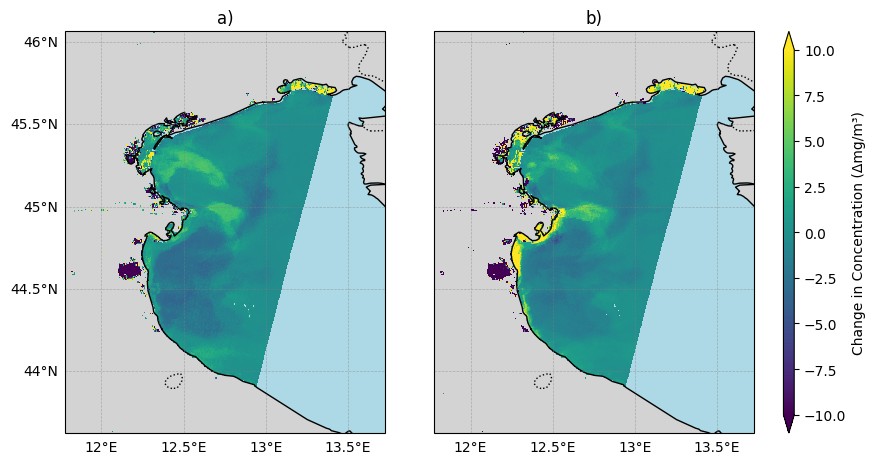

In [88]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

fig = plt.figure(figsize=(9, 4.75))

gs = GridSpec(1, 3, width_ratios=[1, 1, 0.03], height_ratios=[1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, diff_s3[:,:], transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, diff_tsm_s3[:,:], transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))  
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("b)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', extend='both', shrink=0.5).set_label('Change in Concentration (Δmg/m³)')

plt.tight_layout()
plt.savefig('aeronetvenice_s3_difference')
plt.show()



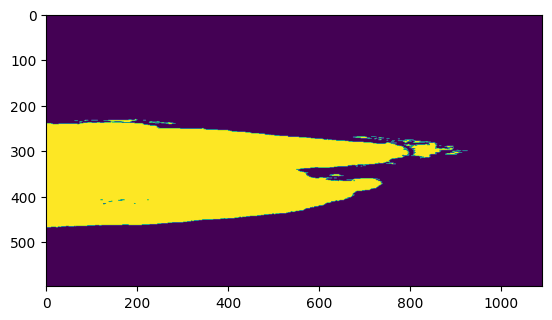

In [17]:
plt.imshow(mask)

In [25]:
corr_matrix = np.corrcoef(diff_hypso_normalized[mask], diff_s3_normalized[mask])

In [26]:
corr_matrix

array([[1.        , 0.21073184],
       [0.21073184, 1.        ]])

In [27]:


from sklearn.metrics import mutual_info_score


bins = 100
diff_hypso_disc = np.digitize(diff_hypso[mask], bins=np.linspace(0, 1, bins))
diff_s3_disc = np.digitize(diff_s3[mask], bins=np.linspace(0, 1, bins))


mi = mutual_info_score(diff_hypso_disc, diff_s3_disc)



In [28]:
print(mi)

0.19687952623854632


Text(0.5, 0, 'Index')

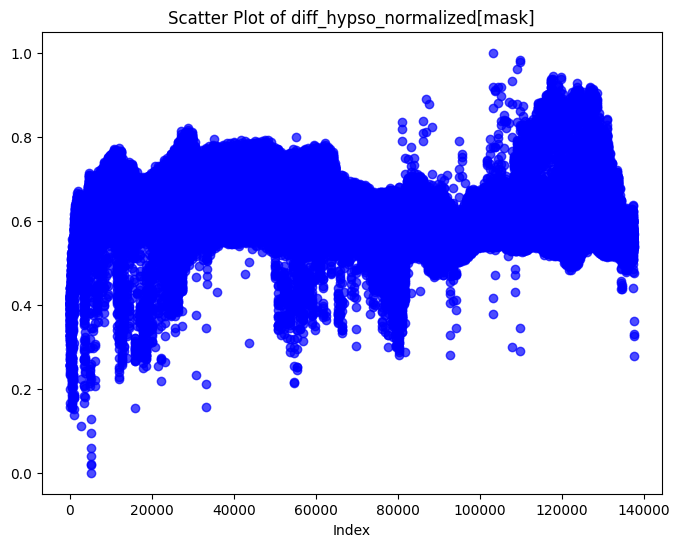

In [29]:

plt.figure(figsize=(8, 6))
plt.scatter(range(len(diff_hypso_normalized[mask])), diff_hypso_normalized[mask], color='blue', alpha=0.7)
plt.title('Scatter Plot of diff_hypso_normalized[mask]')
plt.xlabel('Index')


Text(0.5, 0, 'Index')

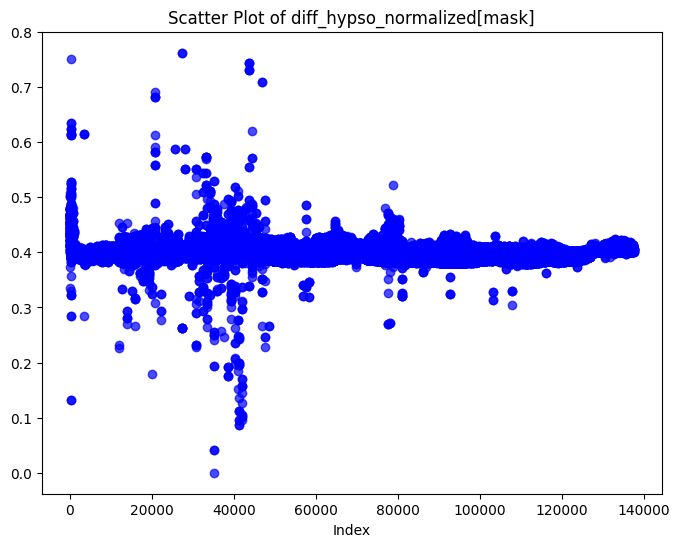

In [33]:

plt.figure(figsize=(8, 6))
plt.scatter(range(len(diff_s3_normalized[mask])), diff_s3_normalized[mask], color='blue', alpha=0.7)
plt.title('Scatter Plot of diff_hypso_normalized[mask]')
plt.xlabel('Index')


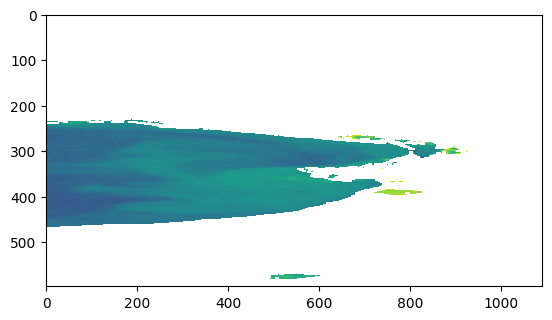

In [ ]:
plt.imshow()

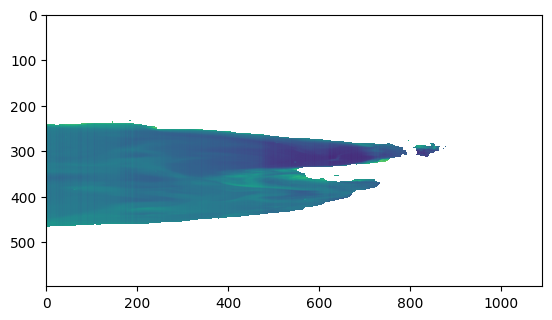

In [108]:
plt.imshow(X1[2,:,:])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


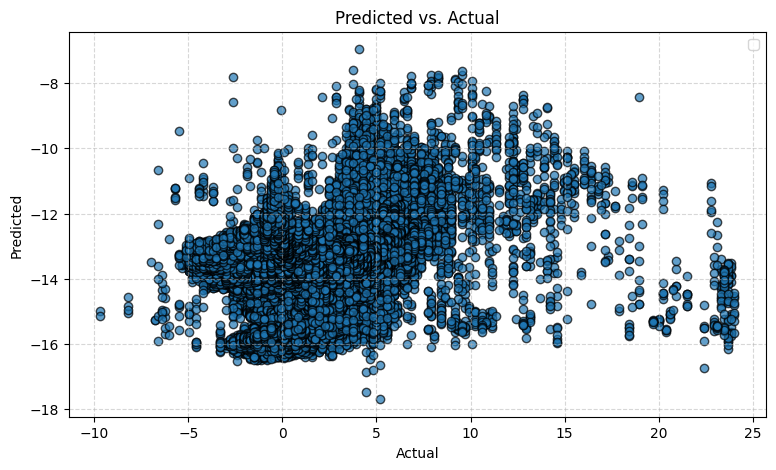

In [131]:
import matplotlib.pyplot as plt
import numpy as np

pred = 1*X1[2,:,:]
actual = 10*sentinel_tsm_granules[0][:,:]

#actual = (sentinel_tsm_granules[0][:,:] - np.nanmin(sentinel_tsm_granules[0][:,:])) / (np.nanmax(sentinel_tsm_granules[0][:,:]) - np.nanmin(sentinel_tsm_granules[0][:,:]))


mask = ~np.isnan(pred) & ~np.isnan(actual)

pred[~mask] = np.nan
actual[~mask] = np.nan

plt.figure(figsize=(9,5))


plt.scatter(actual.flatten(), pred.flatten(), alpha=0.7, edgecolor='k')

# 1:1 line (perfect agreement)
lims_actual = [0, 1]
lims_pred = [0, 10]

#plt.xlim(0,1)
#plt.ylim(lims_pred)

#plt.plot(lims_actual, lims_pred, 'r--', label="1:1 line")

# Labels and style
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
#plt.axis("equal")  # keep x and y scales the same
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


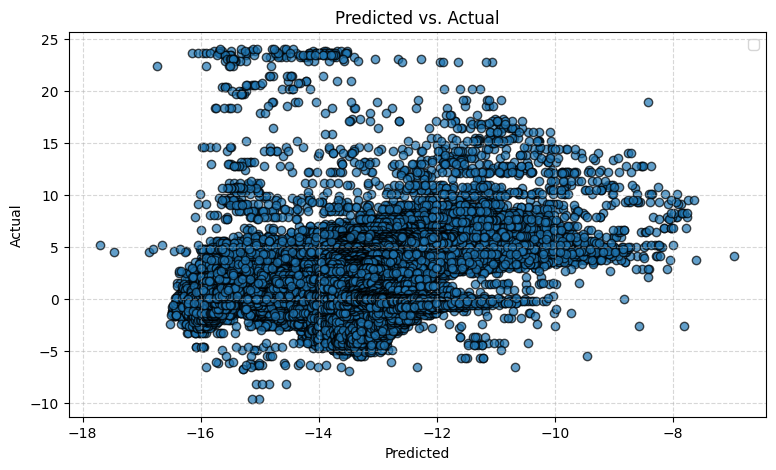

In [156]:
import matplotlib.pyplot as plt
import numpy as np

pred = 1*X1[2,:,:]
actual = 10*sentinel_tsm_granules[0][:,:]

#actual = (sentinel_tsm_granules[0][:,:] - np.nanmin(sentinel_tsm_granules[0][:,:])) / (np.nanmax(sentinel_tsm_granules[0][:,:]) - np.nanmin(sentinel_tsm_granules[0][:,:]))


mask = ~np.isnan(pred) & ~np.isnan(actual)

pred[~mask] = np.nan
actual[~mask] = np.nan

plt.figure(figsize=(9,5))


plt.scatter(pred.flatten(), actual.flatten(), alpha=0.7, edgecolor='k')


# Labels and style
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Predicted vs. Actual")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
#plt.axis("equal")  # keep x and y scales the same
plt.show()


In [155]:
np.nanmin(10*sentinel_granules[1])

-14.48819

In [136]:
np.nanmin(10*sentinel_granules[1])

-14.48819

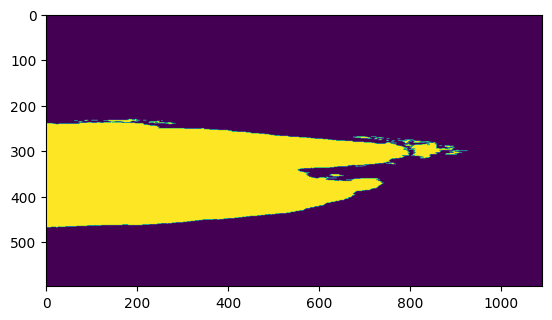

In [116]:
plt.imshow(mask)

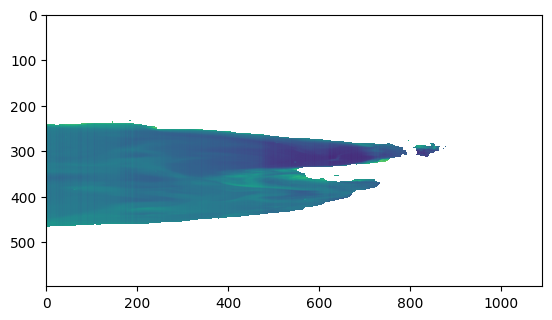

In [115]:
plt.imshow(X1[2,:,:])

In [ ]:
diff_hypso_normalized[~mask] = np.nan
diff_s3_normalized[~mask] = np.nan

In [ ]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

# Function to compute mutual information between two windows
def compute_mutual_information(window1, window2):
    if np.isnan(window1).any() or np.isnan(window2).any():
        return np.nan
    window1_flat = window1.ravel()
    window2_flat = window2.ravel()
    return mutual_info_score(window1_flat, window2_flat)

# Function to generate windowed mutual information map with NaN handling
def windowed_mutual_information_map(array1, array2, window_size):
    rows, cols = array1.shape
    mi_map = np.full((rows - window_size + 1, cols - window_size + 1), np.nan)

    for i in range(mi_map.shape[0]):
        for j in range(mi_map.shape[1]):
            print(str(i) + ', ' + str(j))
            window1 = array1[i:i+window_size, j:j+window_size]
            window2 = array2[i:i+window_size, j:j+window_size]
            mi_map[i, j] = compute_mutual_information(window1, window2)

    return mi_map

# Example 2D arrays with NaNs
array1 = diff_hypso_normalized
array2 = diff_s3_normalized
window_size = 11

# Generate and plot the mutual information map
mi_map = windowed_mutual_information_map(array1, array2, window_size)
plt.imshow(mi_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mutual Information')
plt.title('Windowed Mutual Information Map with NaN Handling')
plt.show()

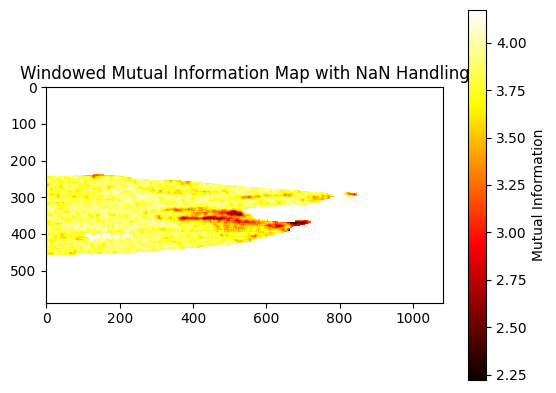

In [61]:
plt.imshow(mi_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mutual Information')
plt.title('Windowed Mutual Information Map with NaN Handling')
plt.show()

In [62]:
corr_array = np.full(diff_hypso_normalized.shape, np.nan)

In [63]:
corr_array[0:mi_map.shape[0], 0:mi_map.shape[1]] = mi_map

In [64]:
mi_map.shape

(588, 1082)

In [65]:
mi_map[:1092,:598].shape

(588, 598)

In [66]:
sentinel_granules[1].shape

(598, 1092)

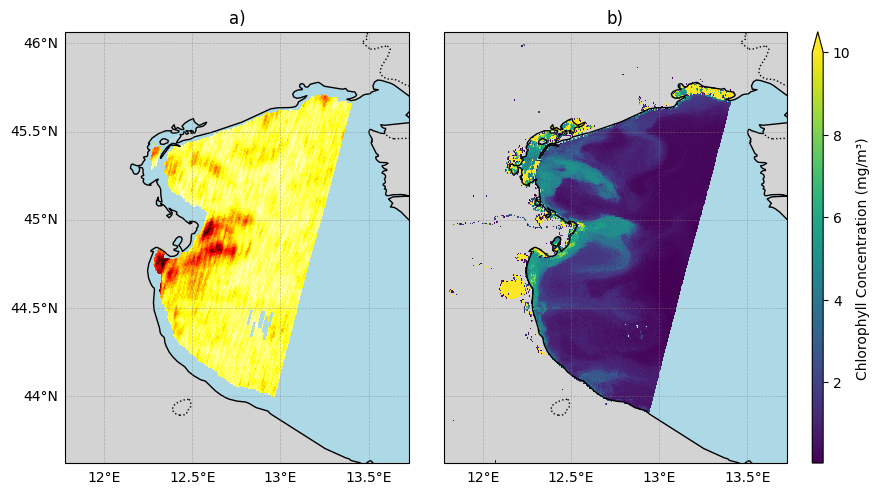

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec


extent = [np.min(X1_lons)+0.4, np.max(X1_lons)-0.2, np.min(X1_lats)+0.7, np.max(X1_lats)-1.6]

fig = plt.figure(figsize=(9, 5))

gs = GridSpec(1, 3, width_ratios=[1, 1, 0.03], height_ratios=[1])

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cax1 = fig.add_subplot(gs[0, 2])

ax = ax1
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, corr_array, transform=ccrs.PlateCarree(), cmap='hot')
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Chlorophyll Concentration (mg/m³)')
ax.set_title("a)")

ax = ax2
ax.set_extent(extent)
mesh = ax.pcolormesh(X1_lons, X1_lats, 10**sentinel_granules[1][:,:], transform=ccrs.PlateCarree(), vmax=10)
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False    # Remove y-axis labels
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xlocator = mticker.FixedLocator(np.arange(12, 14.5, 0.5))  
#plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05, extend='max', shrink=0.66, aspect=30).set_label('Component Amplitude (a.u.)')
ax.set_title("b)")

ax = cax1
fig.colorbar(mesh, cax=cax1, orientation='vertical', extend='max', shrink=0.5).set_label('Chlorophyll Concentration (mg/m³)')

plt.tight_layout()
plt.savefig('aeronetvenice_s3_chl')
plt.show()



In [ ]:
result_cor = []
p_value = []

for lat in range(len(ds1['LAT'])):
for lon in range(len(ds1['LON'])):
try:
corr, p = sp.stats.pearsonr(sic[:, lat, lon], spco2[:, lat, lon])
except ValueError:
corr = np.nan
p = np.nan
result_cor.append((corr, float(ds1['LAT'][lat]), float(ds1['LON'][lon])))
p_value.append((p, float(ds1['LAT'][lat]), float(ds1['LON'][lon])))

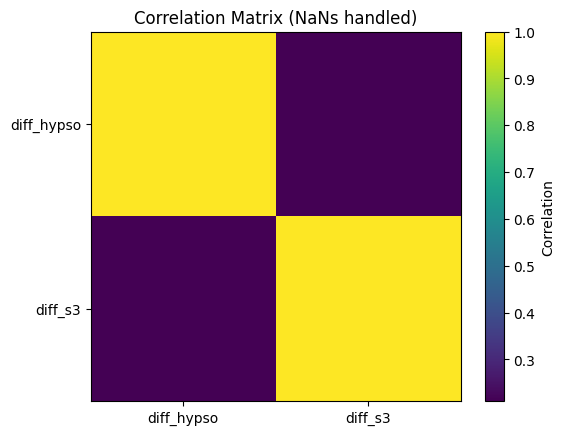

In [215]:

plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks([0, 1], ['diff_hypso', 'diff_s3'])
plt.yticks([0, 1], ['diff_hypso', 'diff_s3'])
plt.title('Correlation Matrix (NaNs handled)')
plt.show()


In [ ]:
# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(diff_hypso, diff_s3)[0, 1]
print(f"Spatial correlation (Pearson): {correlation:.4f}")


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [138]:
import numpy as np
from scipy.stats import pearsonr

def concordance_correlation_coefficient(x, y):
    """Concordance correlation coefficient (CCC) between two arrays."""
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    
    # remove NaNs if present
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)
    sd_x, sd_y = np.std(x, ddof=1), np.std(y, ddof=1)
    
    r, _ = pearsonr(x, y)
    
    ccc = (2 * r * sd_x * sd_y) / (var_x + var_y + (mean_x - mean_y) ** 2)
    return ccc, r

In [145]:
x = 1*X1[2,:,:]
y = 10*sentinel_granules[0][:,:]
ccc, r = concordance_correlation_coefficient(x,y)
print("Pearson r:", r)
print("CCC:", ccc)

x = 1*X1[2,:,:]
y = 10*sentinel_tsm_granules[0][:,:]
ccc, r = concordance_correlation_coefficient(x,y)
print("Pearson r:", r)
print("CCC:", ccc)

x = 1*X2[2,:,:]
y = 10*sentinel_granules[1][:,:]
ccc, r = concordance_correlation_coefficient(x,y)
print("Pearson r:", r)
print("CCC:", ccc)

x = 1*X2[2,:,:]
y = 10*sentinel_tsm_granules[1][:,:]
ccc, r = concordance_correlation_coefficient(x,y)
print("Pearson r:", r)
print("CCC:", ccc)

Pearson r: 0.2541007394927638
CCC: 0.008360562442647513
Pearson r: 0.22377505522703375
CCC: 0.005633023856477457
Pearson r: 0.21959882042650802
CCC: 0.04543686439547041
Pearson r: 0.2450473400208099
CCC: 0.0656360606649795


In [174]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

def concordance_correlation_coefficient(x, y):
    """Concordance correlation coefficient (CCC)."""
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)
    sd_x, sd_y = np.std(x, ddof=1), np.std(y, ddof=1)
    
    r, _ = pearsonr(x, y)
    ccc = (2 * r * sd_x * sd_y) / (var_x + var_y + (mean_x - mean_y) ** 2)
    return ccc

def compare_rasters(x, y, bins=30):
    """Compute multiple comparison metrics between two rasters."""


    mask = ~np.isnan(x) & ~np.isnan(y)
    x_mi = x[mask].reshape(-1, 1)  # sklearn expects 2D features
    y_mi = y[mask]
    mi = mutual_info_regression(x_mi, y_mi, random_state=0)


    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    
    # mask NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    
    # Pearson
    pearson_r, _ = pearsonr(x, y)
    
    # Spearman
    spearman_rho, _ = spearmanr(x, y)
    
    # CCC
    ccc = concordance_correlation_coefficient(x, y)
    
    # Errors
    diff = y - x
    rmse = np.sqrt(np.mean(diff**2))
    mae = np.mean(np.abs(diff))
    bias = np.mean(diff)
    
    # Mutual Information (discretize into bins)
    #x_binned = np.digitize(x, np.histogram(x, bins=bins)[1]) 
    #y_binned = np.digitize(y, np.histogram(y, bins=bins)[1])
    #mi = mutual_info_score(x_binned, y_binned)

    
    
    return {
        "Pearson r": pearson_r,
        "Spearman rho": spearman_rho,
        "CCC": ccc,
        "RMSE": rmse,
        "MAE": mae,
        "Bias": bias,
        "Mutual Information regression": mi[0]
    }

In [ ]:

import numpy as np

# Example rasters (flattened)
x = X2_normalized.flatten()
y = 10*sentinel_granules[1][:,:].flatten()

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask].reshape(-1, 1)  # sklearn expects 2D features
y = y[mask]

# Run MI
mi = mutual_info_regression(x, y, random_state=0)
print("Mutual Information:", mi[0])

Mutual Information: 0.20863201960244737


In [163]:
np.count_nonzero(~np.isnan(X2_normalized))

124438

In [186]:
component = 3
X1_normalized = (X1[component,:,:] - np.nanmin(X1[component,:,:])) / (np.nanmax(X1[component,:,:]) - np.nanmin(X1[component,:,:]))
X2_normalized = (X2[component,:,:] - np.nanmin(X2[component,:,:])) / (np.nanmax(X2[component,:,:]) - np.nanmin(X2[component,:,:]))

x = X1_normalized
y = 10*sentinel_granules[0][:,:]
compare_rasters
results = compare_rasters(x, y)
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Pearson r: -0.5195
Spearman rho: -0.6443
CCC: -0.0091
RMSE: 3.7227
MAE: 3.2002
Bias: 0.4185
Mutual Information regression: 0.5076


In [178]:
x = X2_normalized
y = 10*sentinel_granules[1][:,:]
compare_rasters
results = compare_rasters(x, y)
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Pearson r: 0.2196
Spearman rho: 0.3401
CCC: 0.0036
RMSE: 4.9674
MAE: 3.9787
Bias: -1.8534
Mutual Information regression: 0.2086


In [210]:
# initialize dictionary with empty lists
metrics_dict = {
    "Pearson r": [],
    "Spearman rho": [],
    "CCC": [],
    "RMSE": [],
    "MAE": [],
    "Bias": [],
    "Mutual Information regression": []
}

for component in range(X1.shape[0]):
    # normalize
    X1_normalized = (X1[component, :, :] - np.nanmin(X1[component, :, :])) / (
        np.nanmax(X1[component, :, :]) - np.nanmin(X1[component, :, :])
    )

    X2_normalized = (X2[component, :, :] - np.nanmin(X2[component, :, :])) / (
        np.nanmax(X2[component, :, :]) - np.nanmin(X2[component, :, :])
    )

    x = X2_normalized
    y = 10 * sentinel_granules[1][:, :]

    results = compare_rasters(x, y)

    # append values to each metric’s list
    for k in metrics_dict.keys():
        metrics_dict[k].append(results[k])

# (Optional) convert lists to numpy arrays
import numpy as np
metrics_dict = {k: np.array(v) for k, v in metrics_dict.items()}

# Example usage
print(metrics_dict["Pearson r"])   # array of Pearson r values across components
print(metrics_dict["RMSE"])        # array of RMSE values across components

[-0.13126183 -0.02866741  0.21959882  0.1738702  -0.58212669]
[4.86501059 4.8680312  4.96735565 4.81506692 5.09404191]


In [199]:
product_name = "TSM (Granule 2)"  # customize per run

for comp in range(X2.shape[0]):
    pearson = metrics_dict["Pearson r"][comp]
    ccc = metrics_dict["CCC"][comp]
    spearman = metrics_dict["Spearman rho"][comp]
    mi = metrics_dict["Mutual Information regression"][comp]

    # format to 4 decimals
    row = f"{product_name} & {comp} & {pearson:.4f} & {ccc:.4f} & {spearman:.4f} & {mi:.4f} \\\\"
    print(row)

TSM (Granule 2) & 0 & -0.1228 & -0.0021 & -0.2690 & 0.2559 \\
TSM (Granule 2) & 1 & -0.0194 & -0.0006 & -0.0460 & 0.2784 \\
TSM (Granule 2) & 2 & 0.2450 & 0.0054 & 0.3661 & 0.2258 \\
TSM (Granule 2) & 3 & 0.1963 & 0.0041 & 0.0016 & 0.2876 \\
TSM (Granule 2) & 4 & -0.5287 & -0.0273 & -0.5555 & 0.3932 \\


In [211]:
product_name = "Chla (Granule 1)"  # customize per run

for comp in range(X1.shape[0]):
    rmse = metrics_dict["RMSE"][comp]
    mae = metrics_dict["MAE"][comp]
    bias = metrics_dict["Bias"][comp]

    print(f"{product_name} & {rmse:.4f} & {mae:.4f} & {bias:.4f} \\\\")


Chla (Granule 1) & 4.8650 & 3.8882 & -1.5163 \\
Chla (Granule 1) & 4.8680 & 3.8904 & -1.5336 \\
Chla (Granule 1) & 4.9674 & 3.9787 & -1.8534 \\
Chla (Granule 1) & 4.8151 & 3.8452 & -1.3860 \\
Chla (Granule 1) & 5.0940 & 4.0842 & -2.0101 \\


In [180]:
x = X1_normalized
y = 10*sentinel_tsm_granules[0][:,:]
compare_rasters
results = compare_rasters(x, y)
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Pearson r: 0.2238
Spearman rho: 0.1658
CCC: 0.0121
RMSE: 3.2044
MAE: 2.5730
Bias: 1.0924
Mutual Information regression: 0.3186


In [182]:
x = X2_normalized
y = 10*sentinel_tsm_granules[1][:,:]
compare_rasters
results = compare_rasters(x, y)
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Pearson r: 0.2450
Spearman rho: 0.3661
CCC: 0.0054
RMSE: 3.9394
MAE: 3.1259
Bias: -0.7996
Mutual Information regression: 0.2258
